# SAUCIE Tutorial
*Sparse Autoencoders for Unsupervised Clustering, Imputation, and Embedding*

In [1]:
%matplotlib inline

import glob
import numpy as np
import pandas as pd
import os
import plotting
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import saucie
import saucie_utils as utils
import seaborn as sns

from collections import OrderedDict
from saucie import Saucie
from tensorflow.python import debug as tf_debug
from mpl_toolkits.mplot3d import Axes3D
from saucie_utils import DataSet
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from run import train

np.random.seed(utils.RAND_SEED)
tf.set_random_seed(utils.RAND_SEED)

## Generating Toy Data

In [2]:
N = 5000
D_big = 100
D_small = 20
N_clusters = 10
theta = 1

all_v = []
labels = []
for c in range(N_clusters):
    v = np.zeros((D_big,N))
    for i in range(D_small):
        v[c+i,:] = np.random.normal(c,1,[N])
    all_v.append(v)
    labels.append(c*np.ones(v.shape[1]))
all_v = np.concatenate(all_v, axis=1)

s = math.sin(theta)
c = math.cos(theta)
rotation_Ms = []
for rotation in range(D_big-1):
    m = np.eye(D_big)
    m[rotation,rotation] = c
    m[rotation+1,rotation+1] = c
    m[rotation,rotation+1] = -s
    m[rotation+1,rotation] = s
    rotation_Ms.append(m)

for m in rotation_Ms:
    all_v = m.dot(all_v)

data = all_v.T
data = data - data.min()
data = data / data.max()
labels = np.concatenate(labels, axis=0)

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.9, random_state=utils.RAND_SEED)
data_dict = dict(_data=train_data, _test_data=test_data, _labels=train_labels, _test_labels=test_labels, labeled=True)
data = DataSet(**data_dict)

/home/krishnan/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Loading Examples

**Loading Data**

To load emt data:
```python
data_path = '/data/krishnan/emt_data/data_raw.npz'
dataset = 'emt_rnaseq'
data = utils.load_dataset(dataset, data_path)
```

To load zika data:
```python
data_path = '/data/krishnan/zika_data/gated/combined.npz'
dataset = 'zika'
data = utils.load_dataset(dataset, data_path)
```

**Loading model and config**

To load model and config from file:
```python
config_path = 'saucie_models/zika/17-09-26-runs/0/model.config'
model, config = saucie.load_model_from_config(dataset, config_path)
```

### Toy data

In [76]:
data_path = '/data/krishnan/toy/toy100.npz'
dataset = 'toy100'
data = utils.load_dataset(dataset, data_path)

In [77]:
config = saucie.default_config(dataset)
config['encoder_layers'] = [1024,512,16]
l = len(config['encoder_layers'])
config['act_fn'] = 'tanh'
config['d_act_fn'] = 'tanh'
config['id_norm'] = 'tanh'
id_lam = 1e-3
config['emb_dim'] = 2
zero = np.zeros(l, dtype=utils.FLOAT_DTYPE),
config['sparse_config'] = utils.SparseLayerConfig(3, np.array([0,0,id_lam], dtype=utils.FLOAT_DTYPE))
print('\n'.join([str(x) for x in config.items()]))

('input_dim', 100)
('encoder_layers', [1024, 512, 16])
('emb_dim', 2)
('act_fn', 'tanh')
('d_act_fn', 'tanh')
('use_bias', True)
('loss_fn', 'bce')
('opt_method', 'adam')
('lr', 0.001)
('batch_norm', True)
('id_norm', 'tanh')
('sparse_config', SparseLayerConfig(id_lam=[0.0, 0.0, 0.0010000000474974513],l1_lam=[0.0, 0.0, 0.0, 0.0],l1_w_lam=[0.0, 0.0, 0.0, 0.0],l2_w_lam=[0.0, 0.0, 0.0, 0.0],l1_b_lam=[0.0, 0.0, 0.0, 0.0],l2_b_lam=[0.0, 0.0, 0.0, 0.0]))
('save_path', './saucie_models/toy100')


In [78]:
# TRAINING FLAGS
batch_size = 200     # size of batch during training
num_epochs = 60      # number of epochs to train
patience = 5         # number of epochs to train without improvement, early stopping
log_every = 150      # training loss logging frequency
save_every = 500     # checkpointing frequency
tb_graph = True      # logs graph to TensorBoard if True
tb_summs = True      # logs summaries to TensorBoard if True
verbose = False      # will log in debug mode if True
gpu_mem = 0.45       # percent of gpu mem to allocate

# PLOTTING FLAGS
thresh = .5          # threshold to binarize id regularized layers
save_plots = False    # saves plots if True

steps_per_epoch = data.num_samples // batch_size
num_steps = steps_per_epoch * num_epochs
print('steps per epoch: {}, num steps: {}'.format(steps_per_epoch, num_steps))

steps per epoch: 225, num steps: 13500


### Zika data

In [2]:
data_path = '/data/krishnan/zika_data/gated/combined.npz'
dataset = 'zika'
data = utils.load_dataset(dataset, data_path)

In [20]:
config_path = './saucie_models/zika/17-10-11-runs/3/model.config'
model, config = saucie.load_model_from_config(dataset, config_path)
print('\n'.join([str(x) for x in config.items()]))

('input_dim', 35)
('encoder_layers', [1024, 512, 256, 16])
('emb_dim', 2)
('act_fn', 'tanh')
('d_act_fn', 'tanh')
('use_bias', True)
('loss_fn', 'bce')
('opt_method', 'adam')
('lr', 0.001)
('batch_norm', True)
('id_norm', 'tanh')
('sparse_config', SparseLayerConfig(id_lam=[0.0, 0.0, 0.0, 0.009999999776482582],l1_lam=[0.0, 0.0, 0.0, 0.0],l1_w_lam=[0.0, 0.0, 0.0, 0.0],l2_w_lam=[0.0, 0.0, 0.0, 0.0],l1_b_lam=[0.0, 0.0, 0.0, 0.0],l2_b_lam=[0.0, 0.0, 0.0, 0.0]))


In [61]:
config = saucie.default_config(dataset)
config['encoder_layers'] = [1024, 512, 256]
l = len(config['encoder_layers'])
config['act_fn'] = 'tanh'
config['d_act_fn'] = 'tanh'
config['id_norm'] = 'tanh'
id_lam = 10
config['emb_dim'] = 2
zero = np.zeros(l, dtype=utils.FLOAT_DTYPE)
config['sparse_config'] = utils.SparseLayerConfig(3, np.array([0,0,id_lam], dtype=utils.FLOAT_DTYPE), *[zero for _ in range(5)])
print('\n'.join([str(x) for x in config.items()]))

('input_dim', 35)
('encoder_layers', [1024, 512, 256])
('emb_dim', 2)
('act_fn', 'tanh')
('d_act_fn', 'tanh')
('use_bias', True)
('loss_fn', 'bce')
('opt_method', 'adam')
('lr', 0.001)
('batch_norm', True)
('id_norm', 'tanh')
('sparse_config', SparseLayerConfig(id_lam=[0.0, 0.0, 10.0],l1_lam=[0.0, 0.0, 0.0],l1_w_lam=[0.0, 0.0, 0.0],l2_w_lam=[0.0, 0.0, 0.0],l1_b_lam=[0.0, 0.0, 0.0],l2_b_lam=[0.0, 0.0, 0.0]))
('save_path', './saucie_models/zika')


In [62]:
# TRAINING FLAGS
batch_size = 200     # size of batch during training
num_epochs = 30      # number of epochs to train
patience = 5         # number of epochs to train without improvement, early stopping
log_every = 150      # training loss logging frequency
save_every = 500     # checkpointing frequency
tb_graph = True      # logs graph to TensorBoard if True
tb_summs = True      # logs summaries to TensorBoard if True
verbose = False      # will log in debug mode if True
gpu_mem = 0.45       # percent of gpu mem to allocate

# PLOTTING FLAGS
thresh = .5          # threshold to binarize id regularized layers
save_plots = False    # saves plots if True

steps_per_epoch = data.num_samples // batch_size
num_steps = steps_per_epoch * num_epochs
print('steps per epoch: {}, num steps: {}'.format(steps_per_epoch, num_steps))

steps per epoch: 1689, num steps: 50670


### EMT data

In [23]:
dataset = 'emt_rnaseq'
if os.path.exists('/data/krishnan/emt_data/data_raw.npz'):
    data = DataSet.load('/data/krishnan/emt_data/data_raw.npz')
else:
    data_path = '/data/krishnan/emt_data/data_raw.mat'
    data = utils.load_dataset(dataset, data_path, colnames='/data/krishnan/emt_data/genes.csv')

/home/krishnan/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Fitting PCA on data with shape: (6770, 28910), may take awhile
Done fitting PCA


In [28]:
y.data[:,27669].max()

124.62234

In [29]:
# test = inverse_transform(data,data._data)
test[:,27669].max()

78.940672713626114

In [21]:
y = utils.load_dataset_from_mat('/data/krishnan/emt_data/data_raw.mat')

/home/krishnan/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


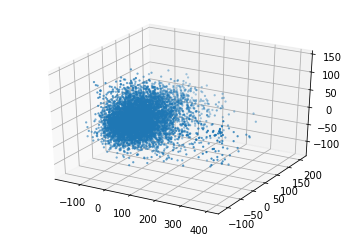

In [3]:
f, ax = plt.subplots(ncols=1, nrows=1, subplot_kw={'projection': '3d'}) 
ax.scatter(data.data[:,0], data.data[:,1], data.data[:,2], s=5, linewidth=0)

In [4]:
data._data.max(axis=0)

array([ 0.21146335,  0.03359663,  0.01730588,  0.02650766,  0.01946211,
        0.01832337,  0.01568082,  0.00780939,  0.01537913,  0.00833208,
        0.00773682,  0.00560645,  0.00506391,  0.01022383,  0.00805351,
        0.00561593,  0.00875059,  0.00540076,  0.00499428,  0.00426508,
        0.00538683,  0.00779134,  0.00609055,  0.00425216,  0.00827981,
        0.00939565,  0.00786201,  0.00419221,  0.00462354,  0.00381905])

In [8]:
def inverse_transform(data, x=None):
    if x is None:
        x = np.concatenate([data.data, data.test_data])
#     x = x * (data._max - data._min) + data._min
    return x.dot(data._components) + data._mean_offset

In [6]:
data._max

array([ 0.21492568,  0.03359658,  0.01730579,  0.02650766,  0.0194621 ,
        0.0183237 ,  0.01568053,  0.00797168,  0.0153785 ,  0.00859349,
        0.00773685,  0.00560642,  0.00506391,  0.01022383,  0.00805356,
        0.00561602,  0.00875074,  0.00539755,  0.00499683,  0.00426299,
        0.00538742,  0.00777885,  0.00607953,  0.00427204,  0.00826036,
        0.0094357 ,  0.00767492,  0.00432315,  0.00454678,  0.00403593])

In [3]:
config = saucie.default_config(dataset)
config['input_dim'] = data.data.shape[1]
config['encoder_layers'] = [1024,512]
l = len(config['encoder_layers'])
config['loss_fn'] = 'mse'
config['act_fn'] = 'tanh'
config['d_act_fn'] = 'tanh'
config['id_norm'] = 'tanh'
config['batch_norm'] = False
config['emb_dim'] = 2
id_lam = 0
zero = np.zeros(l, dtype=utils.FLOAT_DTYPE),
config['sparse_config'] = utils.SparseLayerConfig(2, np.array([0,0], dtype=utils.FLOAT_DTYPE))
print('\n'.join([str(x) for x in config.items()]))

('input_dim', 15)
('encoder_layers', [1024, 512, 256])
('emb_dim', 2)
('act_fn', 'tanh')
('d_act_fn', 'tanh')
('use_bias', True)
('loss_fn', 'mse')
('opt_method', 'adam')
('lr', 0.001)
('batch_norm', False)
('id_norm', 'tanh')
('sparse_config', SparseLayerConfig(id_lam=[0.0, 0.0, 0.0],l1_lam=[0.0, 0.0, 0.0, 0.0],l1_w_lam=[0.0, 0.0, 0.0, 0.0],l2_w_lam=[0.0, 0.0, 0.0, 0.0],l1_b_lam=[0.0, 0.0, 0.0, 0.0],l2_b_lam=[0.0, 0.0, 0.0, 0.0]))
('save_path', './saucie_models/emt_rnaseq')


In [4]:
# TRAINING FLAGS
batch_size = 100     # size of batch during training
num_epochs = 70      # number of epochs to train
patience = 10        # number of epochs to train without improvement, early stopping
log_every = 100       # training loss logging frequency
save_every = 200      # checkpointing frequency
tb_graph = True      # logs graph to TensorBoard if True
tb_summs = True      # logs summaries to TensorBoard if True
verbose = False      # will log in debug mode if True
gpu_mem = 0.45       # percent of gpu mem to allocate

# PLOTTING FLAGS
thresh = .5          # threshold to binarize id regularized layers
save_plots = False    # saves plots if True

steps_per_epoch = data.num_samples // batch_size
num_steps = 10000
print('steps per epoch: {}, num steps: {}'.format(steps_per_epoch, num_steps))

steps per epoch: 67, num steps: 10000


## Train model

In [5]:
sess.close()
tf.reset_default_graph()

NameError: name 'sess' is not defined

In [30]:
!rm -rf ./saucie_models/emt_rnaseq/17-10-13-runs

In [5]:
print('Training on {} dataset'.format(dataset))
if verbose:
    tf.logging.set_verbosity(tf.logging.DEBUG)
else:
    tf.logging.set_verbosity(tf.logging.INFO)

model = Saucie(**config)
plot_dir = model.save_path + '/plots'
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_mem)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
model.build(sess)

Training on emt_rnaseq dataset


### Restore from checkpoint

In [139]:
tf.train.get_checkpoint_state('./saucie_models/zika/17-10-11-runs/3/')

model_checkpoint_path: "./saucie_models/zika/17-10-11-runs/3/model-23500"
all_model_checkpoint_paths: "./saucie_models/zika/17-10-11-runs/3/model-21000"
all_model_checkpoint_paths: "./saucie_models/zika/17-10-11-runs/3/model-21500"
all_model_checkpoint_paths: "./saucie_models/zika/17-10-11-runs/3/model-22000"
all_model_checkpoint_paths: "./saucie_models/zika/17-10-11-runs/3/model-22500"
all_model_checkpoint_paths: "./saucie_models/zika/17-10-11-runs/3/model-23000"
all_model_checkpoint_paths: "./saucie_models/zika/17-10-11-runs/3/model-23500"

In [9]:
model.restore_model(sess, './saucie_models/zika/17-10-11-runs/3/')

INFO:tensorflow:Restoring parameters from ./saucie_models/zika/17-10-11-runs/3/model-23500


True

### Train

In [6]:
## First training, without optimizing id_reg
train(model, sess, data, batch_size, num_steps, thresh, patience, log_every, save_every, save_plots, train_id=False)

Saving all run data to: ./saucie_models/emt_rnaseq/17-10-13-runs/2
INFO:tensorflow:Total steps: 10000
INFO:tensorflow:epoch 0, step 0/10000: loss: 582.893
INFO:tensorflow:epoch 0, step 0/10000: loss: 582.893
INFO:tensorflow:epoch 0, step 1/10000: loss: 538.346
INFO:tensorflow:epoch 0, step 2/10000: loss: 512.99
INFO:tensorflow:epoch 0, step 3/10000: loss: 601.006
INFO:tensorflow:epoch 0, step 4/10000: loss: 497.003
INFO:tensorflow:epoch 0, step 5/10000: loss: 604.461
INFO:tensorflow:epoch 0, step 6/10000: loss: 464.302
INFO:tensorflow:epoch 0, step 7/10000: loss: 530.758
INFO:tensorflow:epoch 0, step 8/10000: loss: 354.729
INFO:tensorflow:epoch 0, step 9/10000: loss: 327.382
INFO:tensorflow:epoch 0, step 10/10000: loss: 411.41
INFO:tensorflow:epoch 0, step 11/10000: loss: 458.993
INFO:tensorflow:epoch 0, step 12/10000: loss: 387.915
INFO:tensorflow:epoch 0, step 13/10000: loss: 542.849
INFO:tensorflow:epoch 0, step 14/10000: loss: 451.896
INFO:tensorflow:epoch 0, step 15/10000: loss: 3

INFO:tensorflow:epoch 19, step 1300/10000: loss: 172.666
INFO:tensorflow:TESTING -- epoch: 20, loss: 201.494
INFO:tensorflow:Saving model, after step 1400
INFO:tensorflow:epoch 20, step 1400/10000: loss: 172.559
INFO:tensorflow:TESTING -- epoch: 21, loss: 187.802
INFO:tensorflow:Best model saved after 21 epochs
INFO:tensorflow:TESTING -- epoch: 22, loss: 191.975
INFO:tensorflow:epoch 22, step 1500/10000: loss: 192.658
INFO:tensorflow:TESTING -- epoch: 23, loss: 187.701
INFO:tensorflow:Best model saved after 23 epochs
INFO:tensorflow:Saving model, after step 1600
INFO:tensorflow:epoch 23, step 1600/10000: loss: 179.38
INFO:tensorflow:TESTING -- epoch: 24, loss: 181.4
INFO:tensorflow:Best model saved after 24 epochs
INFO:tensorflow:TESTING -- epoch: 25, loss: 183.241
INFO:tensorflow:epoch 25, step 1700/10000: loss: 183.511
INFO:tensorflow:TESTING -- epoch: 26, loss: 174.191
INFO:tensorflow:Best model saved after 26 epochs
INFO:tensorflow:Saving model, after step 1800
INFO:tensorflow:epoc

OrderedDict([('loss', 166.74048)])

In [ ]:
## Regular autoencoder embedding (without id_reg)
test_emb = sess.run(model.encoder, feed_dict={model.x_: data.data[:10000], model.is_training_: False})
labels = data.test_labels if data.labeled else None
f, ax = plt.subplots(figsize=(6,6))
plt.scatter(test_emb[:,0], test_emb[:,1], s=5, linewidths=0, c=labels, cmap=plt.cm.jet)
plt.title('Embedding with tanh activation, no id reg')
plt.xlabel('Emb dim 1')
plt.ylabel('Emb dim 2')
plt.show()
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
f.savefig(plot_dir + '/embedding-no-id.png')

In [15]:
### Second training
num_steps = model.global_step_.eval() + steps_per_epoch * 10
train(model, sess, data, batch_size, num_steps, thresh, patience, log_every, save_every, save_plots, train_id=True)

Saving all run data to: ./saucie_models/emt_rnaseq/17-10-13-runs/0
INFO:tensorflow:Total steps: 1515
INFO:tensorflow:Saving model, after step 1200
INFO:tensorflow:epoch 35, step 1200/1515: loss: 0.0126921, recons_loss: 0.0125379, id_loss: 0.000154176
INFO:tensorflow:TESTING -- epoch: 36, loss: 0.011972, recons_loss: 0.0118248, id_loss: 0.000147132
INFO:tensorflow:Best model saved after 36 epochs
INFO:tensorflow:TESTING -- epoch: 37, loss: 0.011839, recons_loss: 0.0117026, id_loss: 0.000136417
INFO:tensorflow:Best model saved after 37 epochs
INFO:tensorflow:TESTING -- epoch: 38, loss: 0.0118739, recons_loss: 0.0117457, id_loss: 0.00012813
INFO:tensorflow:epoch 38, step 1300/1515: loss: 0.0111488, recons_loss: 0.0110237, id_loss: 0.000125156
INFO:tensorflow:TESTING -- epoch: 39, loss: 0.0117991, recons_loss: 0.0116774, id_loss: 0.000121663
INFO:tensorflow:Best model saved after 39 epochs
INFO:tensorflow:TESTING -- epoch: 40, loss: 0.0119349, recons_loss: 0.0118185, id_loss: 0.000116403
I

OrderedDict([('loss', 0.011787595),
             ('recons_loss', 0.011687944),
             ('id_loss', 9.9651508e-05)])

In [20]:
acts_ = tf.get_collection('id_normalized_activations')
act = sess.run(acts_[0], feed_dict={model.x_: data.data[:10000], model.is_training_: False})
clusts = utils.binarize(act)

Unique binary clusters: 5623


KeyboardInterrupt: 

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


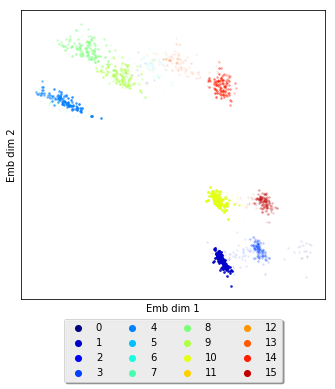

In [11]:
test_emb2 = sess.run(model.encoder, feed_dict={model.x_: data.data[:10000], model.is_training_: False})
f, ax = plt.subplots(figsize=(5,5))
test_emb2 = test_emb2[clusts != -1]
old_clusts = clusts.copy()
clusts = clusts[clusts != -1]
unique_clusters = np.unique(clusts)
num_clusters = len(unique_clusters)
relabel = np.zeros(len(clusts))
if num_clusters < 40:
    colors = [plt.cm.jet(float(i) / num_clusters) for i in range(num_clusters)]
    for i in range(num_clusters):
        label = np.unique(clusts)[i]
        subs = clusts == label
        relabel[subs] = i
        plt.scatter(test_emb2[subs, 0], test_emb2[subs, 1], s=5, linewidths=0, c=colors[i],
                    label=str(i), alpha=.1)
    lgnd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=4)
    for lh in lgnd.legendHandles:
        lh._sizes = [50]
        lh.set_alpha(1)
else:
    plt.scatter(test_emb2[:,0], test_emb2[:,1], s=5, linewidths=0)

plt.xticks([])
plt.yticks([])
# plt.title('Embedding with tanh activation, with id_reg={}, {} clusts'.format(id_lam, num_clusters))
plt.xlabel('Emb dim 1')
plt.ylabel('Emb dim 2')
plt.show()
plt.subplots_adjust(bottom=-0.05)
plot_dir = './plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
f.savefig(plot_dir + '/embedding.png', bbox_extra_artists=(lgnd,), bbox_inches='tight')

In [7]:
# print(plot_dir)
markers = [x.strip().split('_')[-1] for x in open('/data/krishnan/zika_data/gated/markers.csv').readlines()]
plotting.plot_cluster_linkage_heatmap(x['x'][old_clusts != -1], relabel, markers, save_file='./plots/clusters.png')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


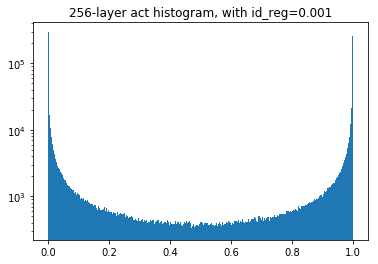

In [166]:
f, ax = plt.subplots(1,1)
plt.hist(act.flatten(),bins=1000)
ax.set_yscale('log')
ax.set_title('{}-layer act histogram, with id_reg={}'.format(act.shape[1], id_lam))
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
f.savefig(plot_dir + '/id-hist.png')
plt.show()

## Analysis

### Toy data

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [106]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/krishnan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Normalized confusion matrix


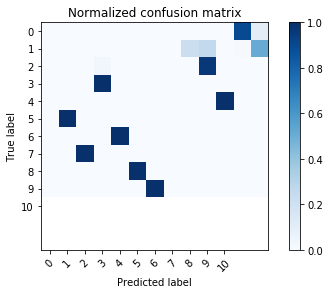

In [108]:
cnf_matrix = confusion_matrix(data.test_labels[bin_act != -1.], (bin_act + 1)[bin_act != -1.])
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(range(11)), normalize=True,
                      title='Normalized confusion matrix')

### EMT data

In [29]:
from fuzzywuzzy import process

/home/krishnan/.local/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [7]:
sparse_act_ = tf.get_collection('id_normalized_activations')[0]
sparse_act = sess.run(sparse_act_, feed_dict={model.x_: data.data[:5000], model.is_training_:False})

labels = utils.binarize(sparse_act)

Unique binary clusters: 4999
Cluster counts (greater than 1% of points)



In [35]:
process.extract('ECADHERIN', data._colnames)

[('CAD', 90), ('RIN1', 77), ('RIN2', 77), ('RIN3', 77), ('RINL', 77)]

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


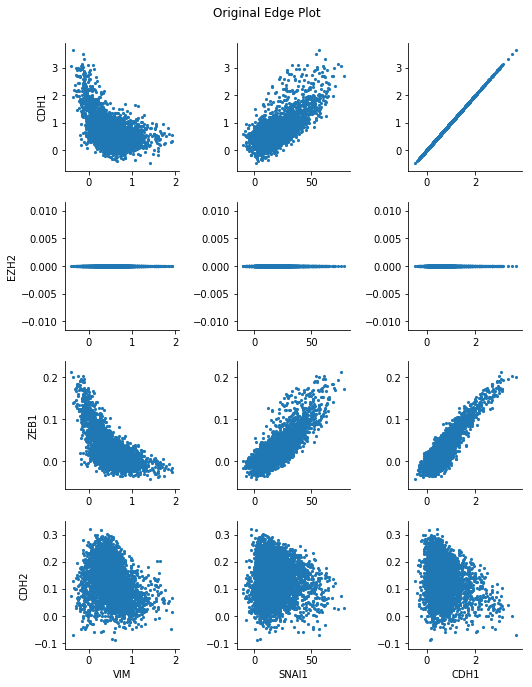

In [14]:
# marker_sub = ['SNAI1', 'TWIST1', 'CD44', 'VIM', 'CAD', 'RIN1']
marker_sub = ['VIM', 'CDH1', 'CDH2', 'EZH2', 'SNAI1', 'ZEB1']# 'MYC', 'FN1']
marker_cols = np.any([np.array(data._colnames) == x for x in marker_sub], axis=0)

df = pd.DataFrame(data=inverse_transform(data,data.data)[:, marker_cols], columns=marker_sub)
p = sns.pairplot(df, plot_kws=dict(s=10, linewidth=0), x_vars=['VIM', 'SNAI1', 'CDH1'], y_vars=['CDH1', 'EZH2', 'ZEB1', 'CDH2'])

for row in p.axes:
    for col in row:
        col.xaxis.reset_ticks()
        col.yaxis.reset_ticks()
p.fig.suptitle('Original Edge Plot')
p.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [9]:
recons = sess.run(model.decoder, feed_dict={model.x_: data.data, model.is_training_: False})
recons_rnaseq = inverse_transform(data, x=recons)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


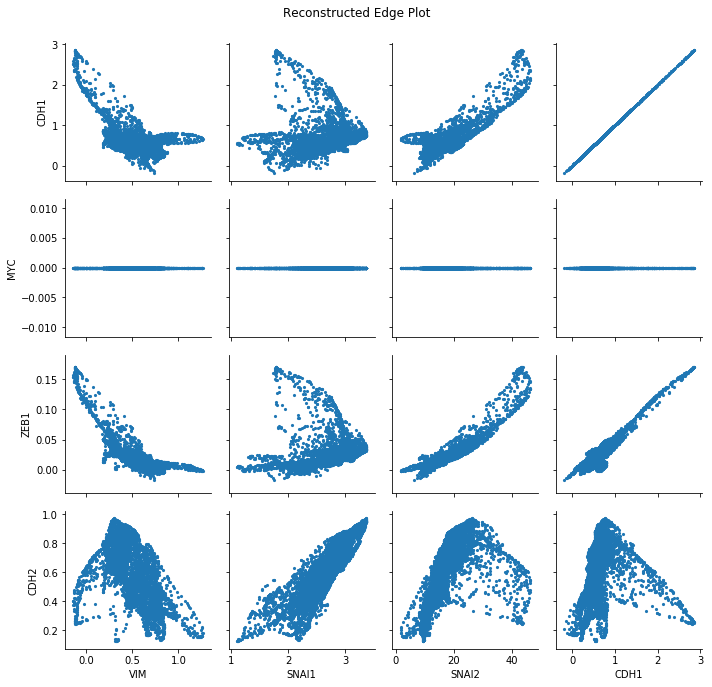

In [13]:
# marker_sub = ['SNAI1', 'TWIST1', 'CD44', 'VIM', 'CAD', 'RIN1']
marker_sub = ['VIM', 'CDH1', 'CDH2', 'MYC', 'SNAI1', 'SNAI2', 'ZEB1']# 'MYC', 'FN1']
marker_cols = np.any([np.array(data._colnames) == x for x in marker_sub], axis=0)

df = pd.DataFrame(data=recons_rnaseq[:, marker_cols], columns=marker_sub)
p = sns.pairplot(df, plot_kws=dict(s=10, linewidth=0), x_vars=['VIM', 'SNAI1', 'SNAI2', 'CDH1'], y_vars=['CDH1', 'MYC', 'ZEB1', 'CDH2'])
"""
for row in p.axes:
    for col in row:
        col.xaxis.reset_ticks()
        col.yaxis.reset_ticks()
"""
p.fig.suptitle('Reconstructed Edge Plot')
p.fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
pca = PCA(3)
pca.fit_transform(recons_rnaseqeq)
f, ax = plt.subplots(fig)

In [ ]:
# marker_sub = ['SNAI1', 'TWIST1', 'CD44', 'VIM', 'CAD', 'RIN1']
marker_sub = ['VIM', 'SNAI1', 'ZEB1', 'EZH2', 'MYC', 'CDH1', 'FN1']
marker_cols = np.any([np.array(data._colnames) == x for x in marker_sub], axis=0)

df = pd.DataFrame(data=recons_rnaseq[:, marker_cols], columns=marker_sub)
p = sns.pairplot(df, plot_kws=dict(s=10, linewidth=0)) 
p.fig.suptitle('Reconstructed Edge Plot')
p.fig.tight_layout(rect=[0, 0.03, 1, 0.95])